# Régression linéaire simple de la conso moyenne sur la température


**Objectif : Prédiction du Total d'énergie soutirée par journée en fonction de la température de la journée sur une région particulière**

*Méthode :* 
- On somme le total d'énergie soutirée par 1/2h sur toute la journée en agrégant tout les points de soutirages 
- On l'associe avec la température sur la journée 
- Réalisation d'une régression simple 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn.preprocessing 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import scale
import operator
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeRegressor 

### Import BDD

In [2]:
enedis_final = pd.read_csv("Données/enedis_final.csv",sep=",")

In [3]:
meteo_reg_df=pd.read_csv("Données/temperature-quotidienne-regionale.csv",";")


## Récuperer toutes les régions de la BDD puis modification des noms
regions=meteo_reg_df["region"].unique()
regions=list(regions)

meteo_reg_df.loc[meteo_reg_df["region"]=="Nouvelle-Aquitaine","region"] = "Nouvelle Aquitaine"
meteo_reg_df.loc[meteo_reg_df["region"]=="Grand Est","region"] = "Grand-Est"

### Pré-processing

In [19]:
enedis_final["date"]= enedis_final["horodate"].apply(lambda x : x[0:10])
enedis_prev = enedis_final.groupby(["date","code_region"])["total_energie_soutiree_wh"].sum().reset_index()
enedis_prev_reg = enedis_prev.merge(meteo_reg_df,left_on=["date","code_region"],right_on=["date","code_insee_region"])

# standardisation des données de températures :
enedis_prev_reg["tmoy_scaled"]=scale(enedis_prev_reg["tmoy"])
enedis_prev_reg

,date,code_region,total_energie_soutiree_wh,id,code_insee_region,region,tmin,tmax,tmoy,tmoy_scaled
0,2020-06-04,11,4.292577e+10,2020-06-04T00:00:00-11,11,Île-de-France,12.14,16.88,14.51,0.122090
1,2020-06-04,24,1.225690e+10,2020-06-04T00:00:00-24,24,Centre-Val de Loire,12.35,18.50,15.43,0.261409
2,2020-06-04,27,1.178381e+10,2020-06-04T00:00:00-27,27,Bourgogne-Franche-Comté,13.88,20.45,17.17,0.524904
3,2020-06-04,28,1.442606e+10,2020-06-04T00:00:00-28,28,Normandie,11.32,14.72,13.02,-0.103547
4,2020-06-04,32,2.184759e+10,2020-06-04T00:00:00-32,32,Hauts-de-France,11.54,15.78,13.66,-0.006629
...,...,...,...,...,...,...,...,...,...,...
5239,2021-08-15,53,6.911228e+08,2021-08-15T00:00:00-53,53,Bretagne,13.27,21.68,17.48,0.571849
5240,2021-08-15,75,1.244148e+09,2021-08-15T00:00:00-75,75,Nouvelle Aquitaine,19.12,24.78,21.95,1.248759
5241,2021-08-15,76,1.301498e+09,2021-08-15T00:00:00-76,76,Occitanie,20.72,28.85,24.79,1.678832
5242,2021-08-15,84,1.392874e+09,2021-08-15T00:00:00-84,84,Auvergne-Rhône-Alpes,19.14,32.55,25.85,1.839352


Pre processing des bdd régionales :

In [20]:
def pre_processing(bdd,region): 

    enedis_region= bdd.loc[bdd.region == region]

    menage=enedis_final[enedis_final["region_x"]==region]["Ensemble"] # conso moyenne selon le nombre de ménages 
    nb_menage=menage.values[0]
    
    enedis_region["conso_moyenne"]=enedis_region["total_energie_soutiree_wh"]/nb_menage

    return enedis_region


Construction des bdd régionales pour les régressions :

In [21]:
enedis_IDF = pre_processing(enedis_prev_reg,"Île-de-France")
enedis_HDF = pre_processing(enedis_prev_reg,"Hauts-de-France")
enedis_PACA = pre_processing(enedis_prev_reg,"Provence-Alpes-Côte d'Azur")
enedis_CVL = pre_processing(enedis_prev_reg,"Centre-Val de Loire")
enedis_Normandie = pre_processing(enedis_prev_reg,"Normandie")
enedis_Occitanie = pre_processing(enedis_prev_reg,"Occitanie")
enedis_ARA = pre_processing(enedis_prev_reg,"Auvergne-Rhône-Alpes")
enedis_BFC= pre_processing(enedis_prev_reg,"Bourgogne-Franche-Comté")
enedis_NA = pre_processing(enedis_prev_reg,"Nouvelle Aquitaine")
enedis_Bretagne = pre_processing(enedis_prev_reg,"Bretagne")
enedis_GE = pre_processing(enedis_prev_reg,"Grand-Est")
enedis_PDL = pre_processing(enedis_prev_reg,"Pays de la Loire")


<ipython-input-20-3ccb8569f3a1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enedis_region["conso_moyenne"]=enedis_region["total_energie_soutiree_wh"]/nb_menage


## Mise en place de la régression :

In [22]:
def decoupe (bdd_region):

    X=bdd_region[["tmoy_scaled"]]
    Y=bdd_region[["conso_moyenne"]]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
    
    return (X,Y, X_train, X_test, Y_train, Y_test )

In [23]:
## Création des échantillons d'apprentissages et de tests

X_ARA,Y_ARA , X_train_ARA, X_test_ARA, Y_train_ARA, Y_test_ARA =decoupe(enedis_ARA)
X_IDF,Y_IDF , X_train_IDF, X_test_IDF, Y_train_IDF, Y_test_IDF =decoupe(enedis_IDF)
X_PACA,Y_PACA , X_train_PACA, X_test_PACA, Y_train_PACA, Y_test_PACA =decoupe(enedis_PACA)
X_HDF,Y_HDF , X_train_HDF, X_test_HDF, Y_train_HDF, Y_test_HDF =decoupe(enedis_HDF)
X_NA,Y_NA , X_train_NA, X_test_NA, Y_train_NA, Y_test_NA =decoupe(enedis_NA)
X_GE,Y_GE , X_train_GE, X_test_GE, Y_train_GE, Y_test_GE =decoupe(enedis_GE)
X_Bretagne,Y_Bretagne , X_train_Bretagne, X_test_Bretagne, Y_train_Bretagne, Y_test_Bretagne =decoupe(enedis_Bretagne)
X_CVL,Y_ICVL, X_train_CVL, X_test_CVL, Y_train_CVL, Y_test_CVL =decoupe(enedis_CVL)
X_BFC,Y_BFC , X_train_BFC, X_test_BFC, Y_train_BFC, Y_test_BFC =decoupe(enedis_BFC)
X_Occitanie,Y_Occitanie , X_train_Occitanie, X_test_Occitanie, Y_train_Occitanie, Y_test_Occitanie =decoupe(enedis_Occitanie)
X_Normandie,Y_Normandie , X_train_Normandie, X_test_Normandie, Y_train_Normandie, Y_test_Normandie =decoupe(enedis_Normandie)
X_PDL,Y_PDL , X_train_PDL, X_test_PDL, Y_train_PDL, Y_test_PDL =decoupe(enedis_PDL)


### Regression sur l'échantillon d'apprentissage 

In [65]:
## Création de la fonction de régression utilisant sklearn 

def reg_sklearn(X_train,Y_train,X_test,Y_test,df_region,region):
    
    model = LinearRegression()
    results=model.fit(X_train,Y_train)

    coeff=results.coef_[0][0]
    intercept=results.intercept_[0]

    R2=model.score(X_train,Y_train)

    Y = df_region["conso_moyenne"].to_numpy()
  
    Y_predicted = model.predict(X_test)


    # Évaluation du modèle
    rmse = mean_squared_error(Y_test, Y_predicted)
    r2 = r2_score(Y_test, Y_predicted)
    # Affichage des valeurs
    print("Pente : " ,coeff)
    print("Ordonnée à l'origine : ", intercept)
    print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
    print('Sccore R2 : ', r2)
    
    # Tracée des valeurs
    # Points de données
    plt.figure(figsize=(20, 8))
    plt.scatter(enedis_IDF["tmoy_scaled"], Y, s=10)
    plt.xlabel('Température moyenne standardisée')
    plt.ylabel("Consommation d'energie moyenne par ménage en Watt")
    plt.title("Regression linéaire de la conso moyenne sur la température pour la région "+region)
    # Valeurs prédites
    plt.scatter(X_test, Y_predicted, color='r')
    plt.show()

    return (coeff,R2,intercept)

Pente :  -3759.063226271207
Ordonnée à l'origine :  11596.30080787167
Racine carrée de l'erreur quadratique moyenne :  5439015.941036617
Sccore R2 :  0.7459351623717789


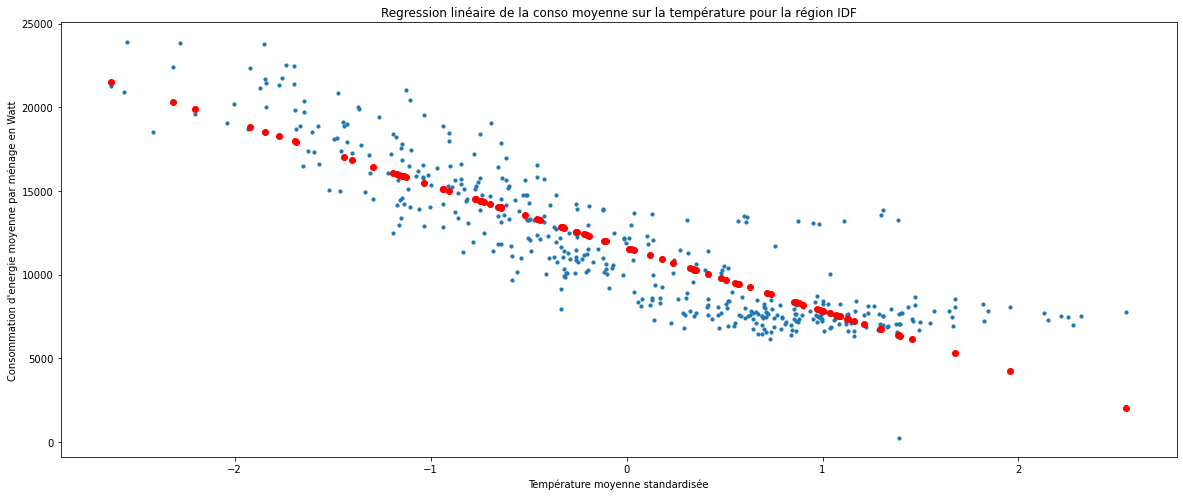

In [66]:
res_reg_IDF,R2_IDF,coeff_reg_IDF = reg_sklearn(X_train_IDF,Y_train_IDF,X_test_IDF,Y_test_IDF,enedis_IDF,"IDF")

Pente :  -3759.063226271207
Ordonnée à l'origine :  11596.30080787167
Racine carrée de l'erreur quadratique moyenne :  5439015.941036617
Sccore R2 :  0.7459351623717789


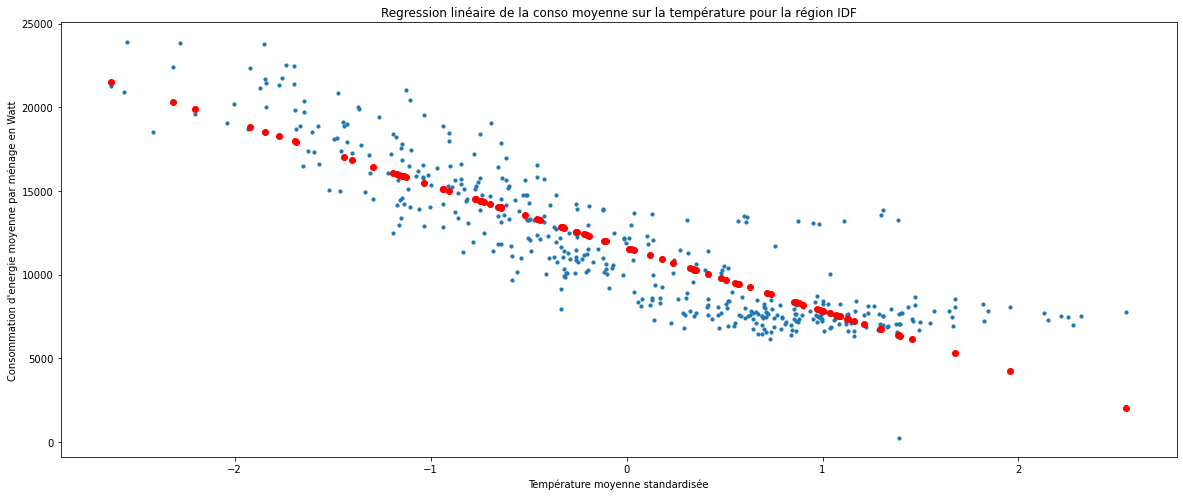

Pente :  -4388.761609750141
Ordonnée à l'origine :  19077.533512870938
Racine carrée de l'erreur quadratique moyenne :  18082739.03654864
Sccore R2 :  0.49406119726987074


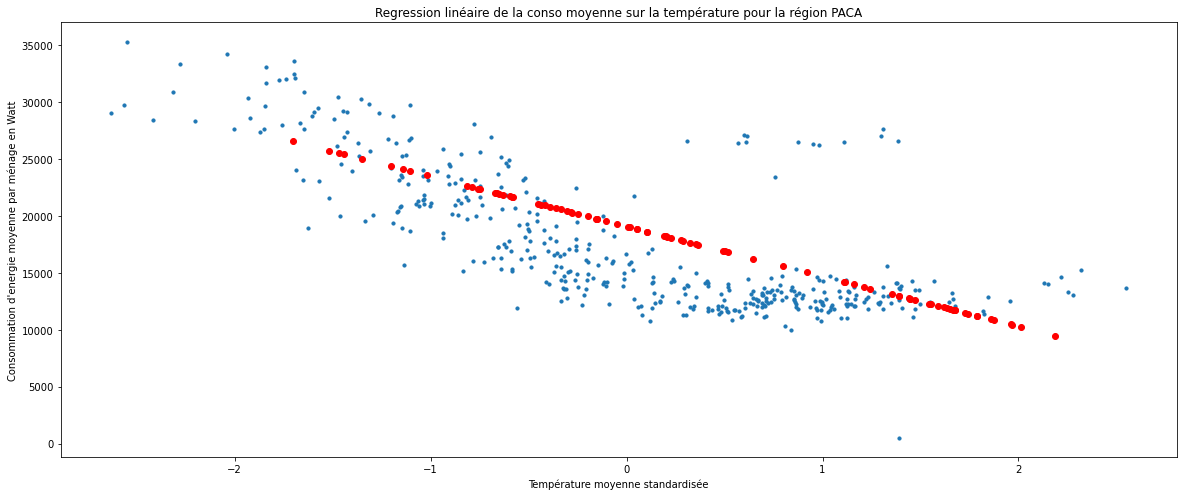

Pente :  -4120.138371406426
Ordonnée à l'origine :  14230.90793309708
Racine carrée de l'erreur quadratique moyenne :  7533895.000963667
Sccore R2 :  0.724484946711416


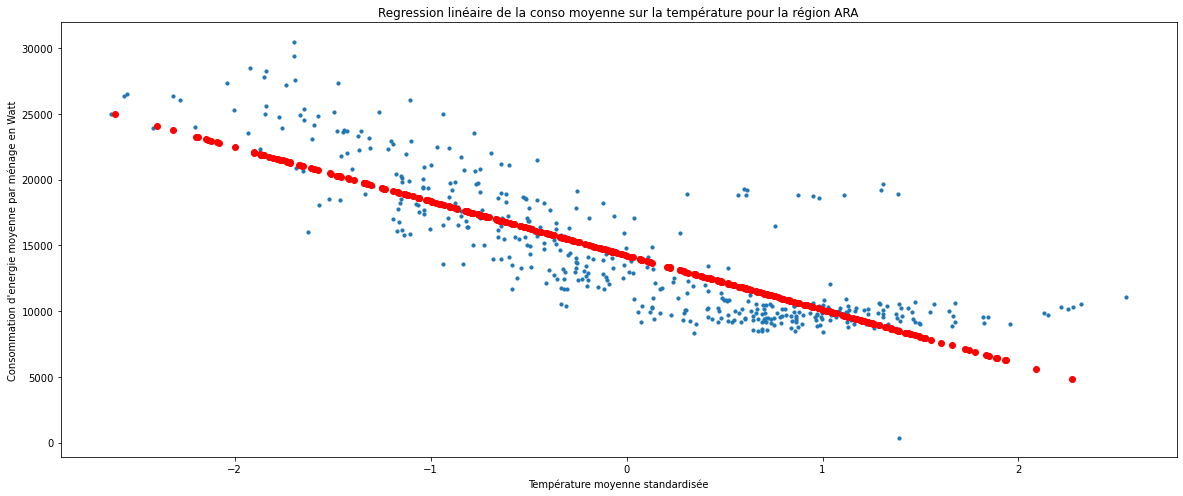

Pente :  -4219.440258971921
Ordonnée à l'origine :  12164.108893839943
Racine carrée de l'erreur quadratique moyenne :  6701365.131730169
Sccore R2 :  0.725709533343226


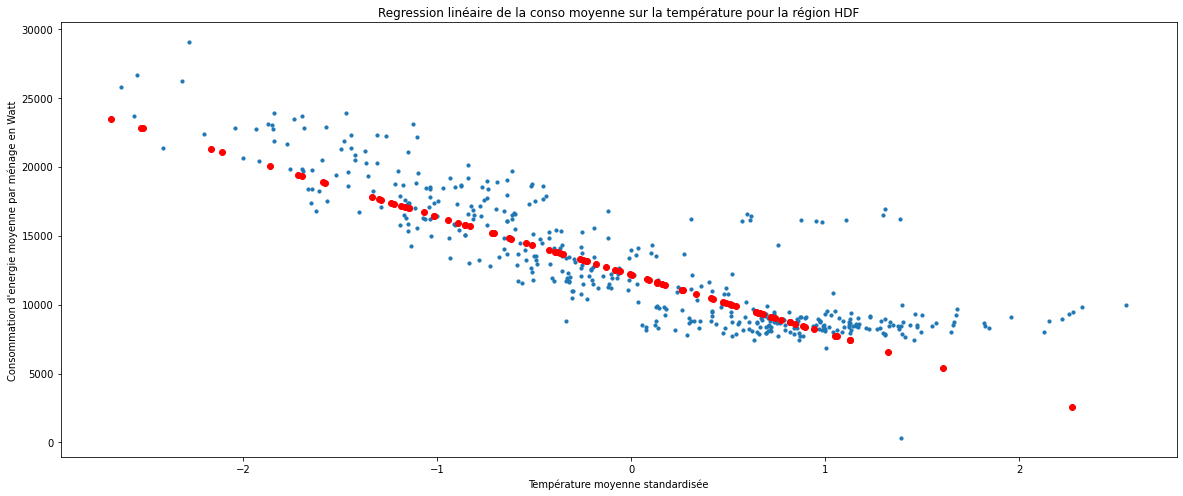

Pente :  -5870.865835424865
Ordonnée à l'origine :  16214.963067904997
Racine carrée de l'erreur quadratique moyenne :  13114880.735793592
Sccore R2 :  0.6989570896285076


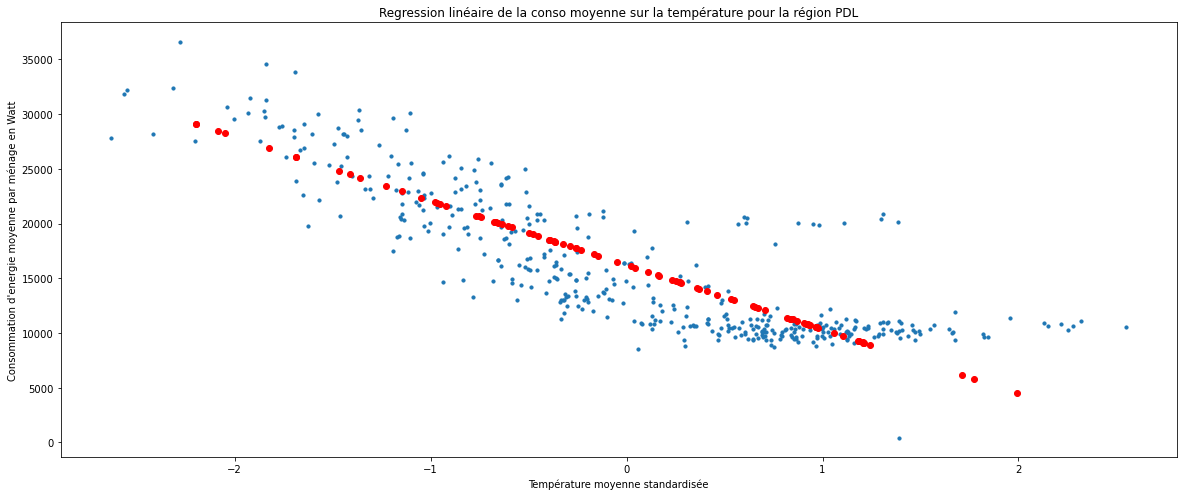

Pente :  -6471.0259301295155
Ordonnée à l'origine :  14977.081505492537
Racine carrée de l'erreur quadratique moyenne :  12703680.215450395
Sccore R2 :  0.7399584881846027


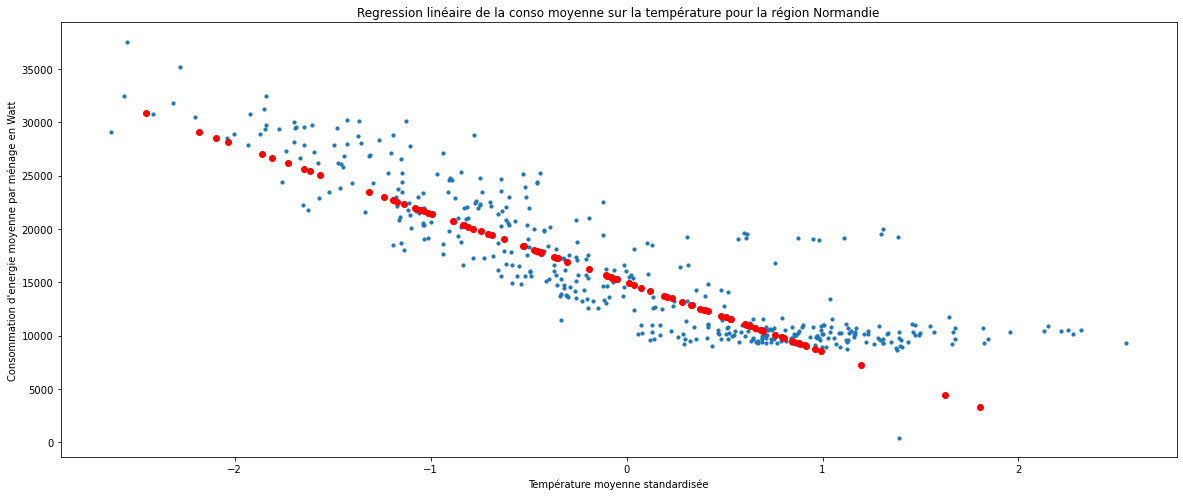

Pente :  -4578.308821483169
Ordonnée à l'origine :  16954.30183392261
Racine carrée de l'erreur quadratique moyenne :  14378121.550641678
Sccore R2 :  0.5636117028669985


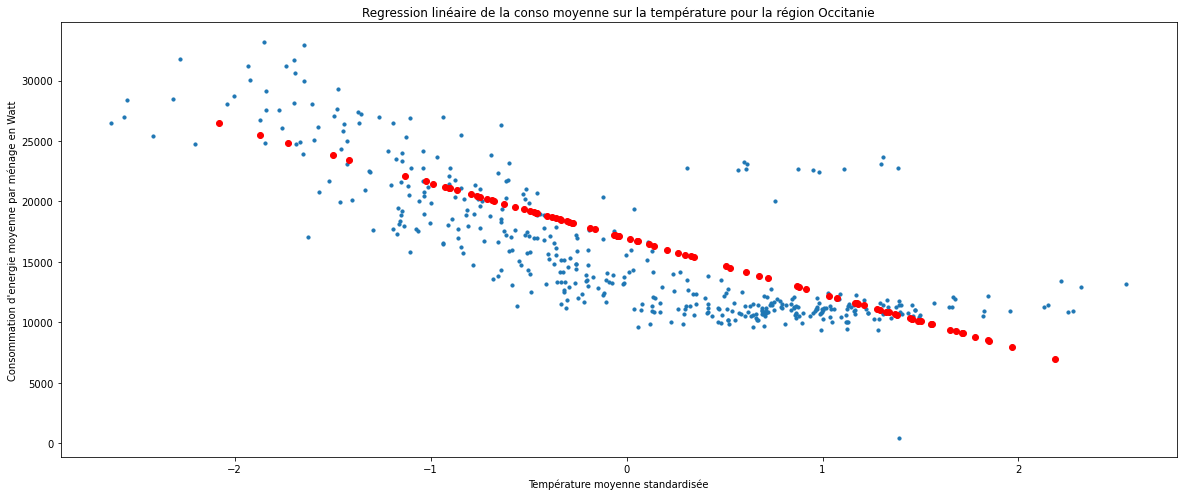

Pente :  -7175.7402890486055
Ordonnée à l'origine :  14859.427897737594
Racine carrée de l'erreur quadratique moyenne :  13484392.084421061
Sccore R2 :  0.7005830741955207


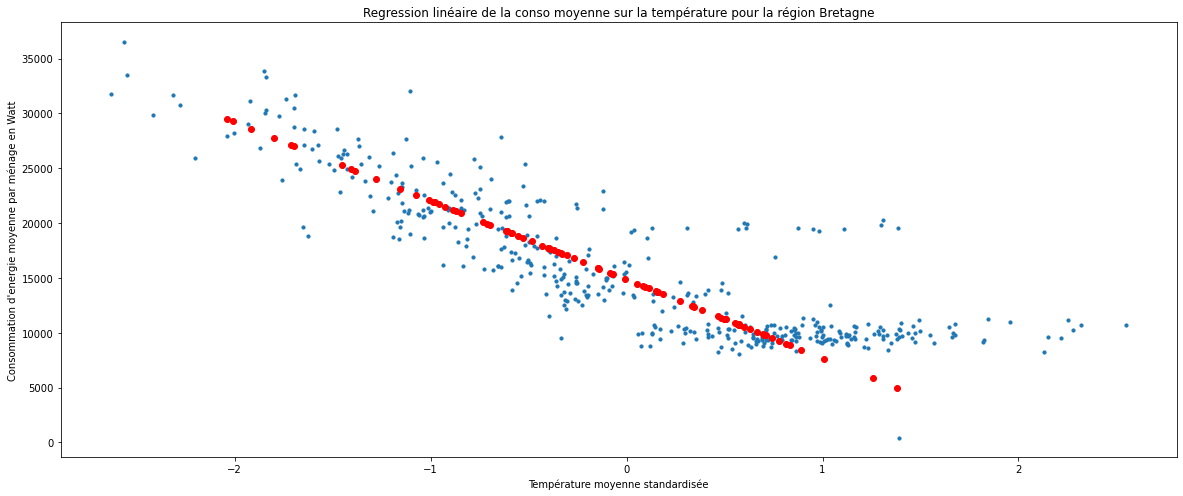

Pente :  -5095.679634912452
Ordonnée à l'origine :  15810.317238152016
Racine carrée de l'erreur quadratique moyenne :  13024024.994862396
Sccore R2 :  0.6210381817347446


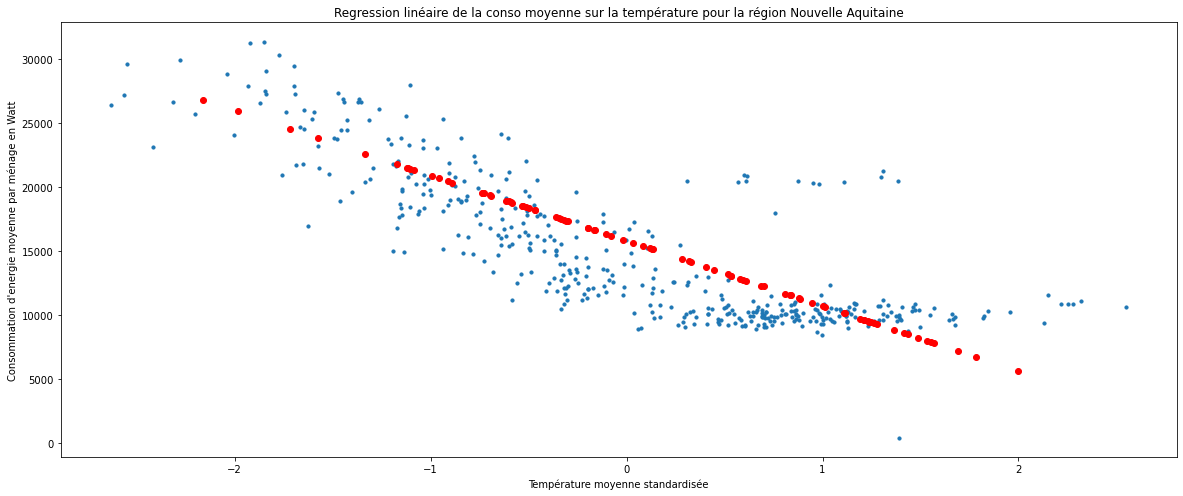

Pente :  -2837.296139533255
Ordonnée à l'origine :  9806.87319080704
Racine carrée de l'erreur quadratique moyenne :  3898742.060990429
Sccore R2 :  0.7235393556795294


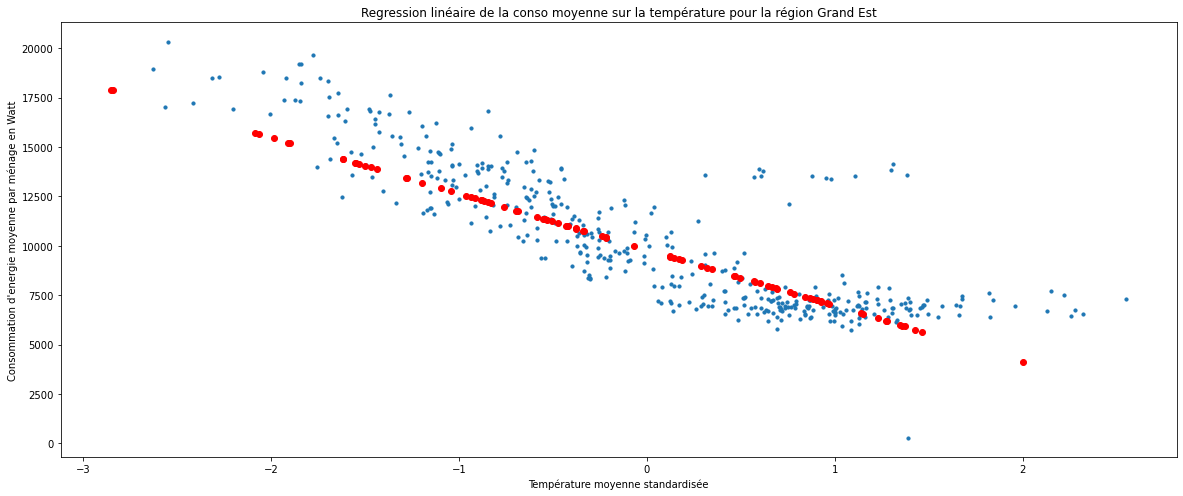

Pente :  -3990.430203839793
Ordonnée à l'origine :  14058.165848293258
Racine carrée de l'erreur quadratique moyenne :  7622972.073804089
Sccore R2 :  0.7084345178209247


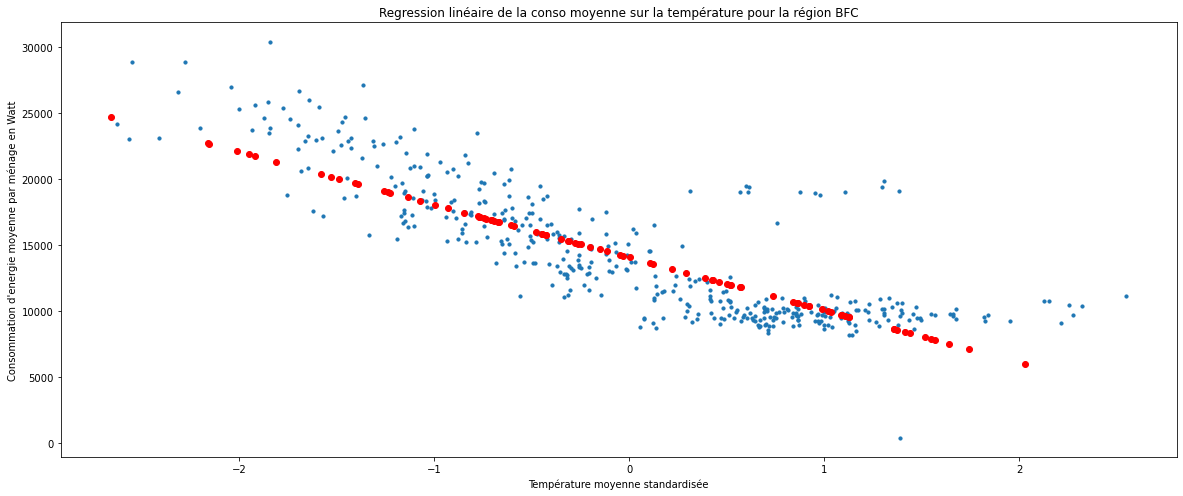

Pente :  -5587.529169129701
Ordonnée à l'origine :  15171.105682466465
Racine carrée de l'erreur quadratique moyenne :  11143187.212885337
Sccore R2 :  0.7360259034097459


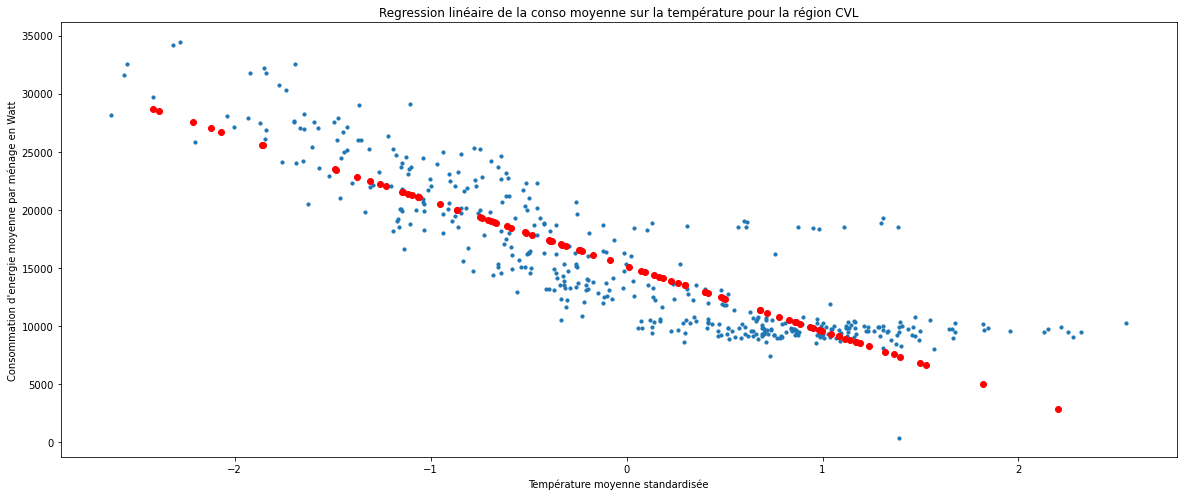

In [67]:
## Stockage des résultats des régressions pour chaque régions 
res_reg_IDF,R2_IDF,coeff_reg_IDF = reg_sklearn(X_train_IDF,Y_train_IDF,X_test_IDF,Y_test_IDF,enedis_IDF,"IDF")
res_reg_PACA,R2_PACA,coeff_reg_PACA = reg_sklearn(X_train_PACA,Y_train_PACA,X_test_PACA,Y_test_PACA,enedis_PACA,"PACA")
res_reg_ARA,R2_ARA,coeff_reg_ARA = reg_sklearn(X_train_ARA,Y_train_ARA,X_train_ARA,Y_train_ARA,enedis_ARA,"ARA")
res_reg_HDF,R2_HDF,coeff_reg_HDF = reg_sklearn(X_train_HDF,Y_train_HDF,X_test_HDF,Y_test_HDF,enedis_HDF,"HDF")
res_reg_PDL,R2_PDL,coeff_reg_PDL = reg_sklearn(X_train_PDL,Y_train_PDL,X_test_PDL,Y_test_PDL,enedis_PDL,"PDL")
res_reg_Normandie,R2_Normandie, coeff_reg_Normandie = reg_sklearn(X_train_Normandie,Y_train_Normandie,X_test_Normandie,Y_test_Normandie,enedis_Normandie,"Normandie")
res_reg_Occitanie,R2_Occitanie,coeff_reg_Occitanie = reg_sklearn(X_train_Occitanie,Y_train_Occitanie,X_test_Occitanie,Y_test_Occitanie,enedis_Occitanie,"Occitanie")
res_reg_Bretagne,R2_Bretagne,coeff_reg_Bretagne = reg_sklearn(X_train_Bretagne,Y_train_Bretagne,X_test_Bretagne,Y_test_Bretagne,enedis_Bretagne,"Bretagne")
res_reg_NA,R2_NA,coeff_reg_NA = reg_sklearn(X_train_NA,Y_train_NA,X_test_NA,Y_test_NA,enedis_NA,"Nouvelle Aquitaine")
res_reg_GE,R2_GE,coeff_reg_GE = reg_sklearn(X_train_GE,Y_train_GE,X_test_GE,Y_test_GE,enedis_GE,"Grand Est")
res_reg_BFC,R2_BFC,coeff_reg_BFC = reg_sklearn(X_train_BFC,Y_train_BFC,X_test_BFC,Y_test_BFC,enedis_BFC,"BFC")
res_reg_CVL,R2_CVL,coeff_reg_CVL= reg_sklearn(X_train_CVL,Y_train_CVL,X_test_CVL,Y_test_CVL,enedis_CVL,"CVL")